# Инструменты для работы с языком 

## Задача: классификация твитов по тональности

У нас есть датасет из твитов, про каждый указано, как он эмоционально окрашен: положительно или отрицательно. Задача: предсказывать эмоциональную окраску.

Скачиваем куски датасета ([источник](http://study.mokoron.com/)): [положительные](https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv?dl=0), [отрицательные](https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv).

In [1]:
# если у вас линукс / мак / collab или ещё какая-то среда, в которой работает wget, можно так:
!wget https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
!wget https://www.dropbox.com/s/r6u59ljhhjdg6j0/negative.csv

--2022-05-06 09:29:25--  https://www.dropbox.com/s/fnpq3z4bcnoktiv/positive.csv
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/fnpq3z4bcnoktiv/positive.csv [following]
--2022-05-06 09:29:25--  https://www.dropbox.com/s/raw/fnpq3z4bcnoktiv/positive.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc64f8f0ad36634006bd472247c.dl.dropboxusercontent.com/cd/0/inline/Bku6yzmGV0oHNfaOaAgq9JKZRYDu8FMx1Iih-srmQ5twsFsDrHeLJekWN2aedfBiAsp8N5uU99_EX798t-ODYh2ptUTAnvRigMjkZoqRggohrZ17CCyP5ssqV7sHvK-OFIOunlzA3J2yopG0CrIByuMeWZiirOhHjvk3zH0EfefMBA/file# [following]
--2022-05-06 09:29:26--  https://ucc64f8f0ad36634006bd472247c.dl.dropboxusercontent.com/cd/0/inline/Bku6yzmGV0oHNfaOaAgq9JKZRYDu8FMx1Iih-srmQ5twsFsDrHeLJekWN2aedfBiAsp8

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

In [3]:
# считываем данные и заполняем общий датасет
positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
positive['label'] = ['positive'] * len(positive)
negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
negative['label'] = ['negative'] * len(negative)
df = positive.append(negative)

In [4]:
df.tail()

,text,label
111918,Но не каждый хочет что то исправлять:( http://...,negative
111919,скучаю так :-( только @taaannyaaa вправляет мо...,negative
111920,"Вот и в школу, в говно это идти уже надо(",negative
111921,"RT @_Them__: @LisaBeroud Тауриэль, не грусти :...",negative
111922,Такси везет меня на работу. Раздумываю приплат...,negative


In [5]:
x_train, x_test, y_train, y_test = train_test_split(df.text, df.label)

## Baseline: классификация необработанных n-грамм

### Векторизаторы

In [6]:
from sklearn.linear_model import LogisticRegression # можно заменить на любимый классификатор
from sklearn.feature_extraction.text import CountVectorizer

Что такое n-граммы:

In [7]:
from nltk import ngrams

In [8]:
sent = 'Если б мне платили каждый раз'.split()
list(ngrams(sent, 1)) # униграммы

[('Если',), ('б',), ('мне',), ('платили',), ('каждый',), ('раз',)]

In [9]:
list(ngrams(sent, 2)) # биграммы

[('Если', 'б'),
 ('б', 'мне'),
 ('мне', 'платили'),
 ('платили', 'каждый'),
 ('каждый', 'раз')]

In [10]:
list(ngrams(sent, 3)) # триграммы

[('Если', 'б', 'мне'),
 ('б', 'мне', 'платили'),
 ('мне', 'платили', 'каждый'),
 ('платили', 'каждый', 'раз')]

In [11]:
list(ngrams(sent, 5)) # ... пентаграммы?

[('Если', 'б', 'мне', 'платили', 'каждый'),
 ('б', 'мне', 'платили', 'каждый', 'раз')]

Самый простой способ извлечь фичи из текстовых данных -- векторизаторы: `CountVectorizer` и `TfidfVectorizer`

Объект `CountVectorizer` делает простую вещь:
* строит для каждого документа (каждой пришедшей ему строки) вектор размерности `n`, где `n` -- количество слов или n-грам во всём корпусе
* заполняет каждый i-тый элемент количеством вхождений слова в данный документ

In [12]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train) # bow -- bag of words (мешок слов)

ngram_range отвечает за то, какие n-граммы мы используем в качестве фичей:<br/>
ngram_range=(1, 1) -- униграммы<br/>
ngram_range=(3, 3) -- триграммы<br/>
ngram_range=(1, 3) -- униграммы, биграммы и триграммы.

В vec.vocabulary_ лежит словарь: мэппинг слов к их индексам:

In [13]:
list(vec.vocabulary_.items())[:10]

[('i_love_on_di_de', 38561),
 ('люблю', 154302),
 ('тебяяяя', 220594),
 ('послала', 189848),
 ('его', 129806),
 ('пу', 198151),
 ('http', 37993),
 ('co', 21524),
 ('0azb1ark5c', 204),
 ('zirconium12', 96652)]

In [14]:
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

In [15]:
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.76      0.76      0.76     27988
    positive       0.77      0.77      0.77     28721

    accuracy                           0.77     56709
   macro avg       0.77      0.77      0.77     56709
weighted avg       0.77      0.77      0.77     56709



Попробуем сделать то же самое для триграмм:

In [16]:
vec = CountVectorizer(ngram_range=(3, 3))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.47      0.72      0.57     18293
    positive       0.82      0.62      0.70     38416

    accuracy                           0.65     56709
   macro avg       0.65      0.67      0.64     56709
weighted avg       0.71      0.65      0.66     56709



(как вы думаете, почему в результатах теперь такой разброс по сравнению с униграммами?)

## TF-IDF векторизация

`TfidfVectorizer` делает то же, что и `CountVectorizer`, но в качестве значений – tf-idf каждого слова.

Как считается tf-idf:

TF (term frequency) – относительная частотность слова в документе:
$$ TF(t,d) = \frac{n_t}{\sum_k n_k} $$

`t` -- слово (term), `d` -- документ, $n_t$ -- количество вхождений слова, $n_k$ -- количество вхождений остальных слов

IDF (inverse document frequency) – обратная частота документов, в которых есть это слово:
$$ IDF(t, D) = \mbox{log} \frac{|D|}{|{d : t \in d}|} $$

`t` -- слово (term), `D` -- коллекция документов

Перемножаем их:
$$TFIDF_(t,d,D) = TF(t,d) \times IDF(i, D)$$

Сакральный смысл – если слово часто встречается в одном документе, но в целом по корпусу встречается в небольшом 
количестве документов, у него высокий TF-IDF.

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [18]:
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.74      0.77      0.75     26764
    positive       0.79      0.76      0.77     29945

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



В этот раз получилось хуже :( Вернёмся к `CountVectorizer`.

## PMI

Можно оценить взаимосвязь слов в корпусе и понять, какие биграммы наиболее часто встречаются в тексте. Для этого можно использовать метрику PMI (Pointwise Mutual Information) - поточечная взаимная информация. Метрика PMI для двух слов вычисляется по формуле:

$$pmi(x; y) = log \frac{p(x,y)}{p(x)p(y)} $$

Здесь p(y|x) - вероятность встретить слово $y$ после $x$, $p(y)$ - вероятность встретить слово $y$.

Оценим важность биграмм в нашем обучающем корпусе.

In [19]:
import nltk
from nltk import collocations 
nltk.download('genesis')
nltk.download('punkt')

print(type(nltk.corpus.genesis.words('english-web.txt')))
bigram_measures = collocations.BigramAssocMeasures()
# bigram_finder.apply_freq_filter(5)
bigram_finder = collocations.BigramCollocationFinder.from_documents([nltk.word_tokenize(x) for x in x_train])
bigrams = bigram_finder.nbest(bigram_measures.pmi, 100)
print(bigrams)

[nltk_data] Downloading package genesis to /root/nltk_data...
[nltk_data]   Unzipping corpora/genesis.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
<class 'nltk.corpus.reader.util.StreamBackedCorpusView'>
[('***ТЫ', 'ЛАПОЧКА'), ('***ахах', 'Ксююю'), ('***сегодня', 'ироска'), ('*FUCK', 'ЛОГИК*'), ('*__________________*', 'вообщеееееееее'), ('*blog', 'Трансформация'), ('*facepalm.jpg*', 'Ебанные'), ('*happy', 'tree*'), ('*linux', '*arch'), ('*°•', '•●♥'), ('*ВЕЧНАЯ', 'ПАМЯТЬ*'), ('*Кукэева', 'минем**Лучшая'), ('*Мне', 'отвёртку'), ('*Оля', 'Фадеева'), ('*ПОТЕКЛИ', 'СЛЮНИ*'), ('*СЛЕЗЫ', 'СЛЕЗЫ*'), ('*аалгах', 'гээх'), ('*барабанная', 'дробь*'), ('*без', 'намёков*'), ('*белая', 'зависть*'), ('*возможную', 'дочь*-*прости'), ('*вот', 'зараза*'), ('*вспоминаю', 'евоные'), ('*вчера', 'перечитывал'), ('*вытирает', 'стекающий'), ('*гениальный', 'вопрос*'), ('*громко', 'смеется*'), ('*довольная', 'ангарская'), ('*ещё', 'глаток*'), (

Можно рассмотреть другие метрики оценки важности биграмм, например, метрику правдоподобия (подробнее про вычисление метрики можно посмотреть [здесь (пункт 5.3.4)](http://www.corpus.unam.mx/cursoenah/ManningSchutze_1999_FoundationsofStatisticalNaturalLanguageProcessing.pdf):

In [20]:
bigrams = bigram_finder.nbest(bigram_measures.likelihood_ratio, 100)
print(bigrams)

[('(', '('), ('RT', '@'), (')', ')'), ('http', ':'), ('!', '!'), (':', 'D'), ('у', 'меня'), (':', '('), (',', 'а'), (',', 'что'), (',', 'но'), (')', 'http'), ('у', 'нас'), ('(', ','), (':', ')'), (':', '-'), (',', '('), (',', ')'), ('?', '?'), ('не', 'могу'), (':', '*'), (')', ','), (',', ':'), ('@', '('), (',', ','), (':', ','), ('(', ':'), ('@', ')'), ('@', ','), ('&', 'lt'), ('со', 'мной'), ('@', ':'), ('(', '@'), (':', ':'), ('gt', ';'), (';', ')'), ('новый', 'год'), (',', '@'), (')', ':'), ('не', 'знаю'), ('@', '@'), ('а', 'я'), (',', 'когда'), ('У', 'меня'), ('потому', 'что'), ('lt', ';'), ('сих', 'пор'), ('&', 'gt'), (';', '('), ('все', 'равно'), ('у', 'тебя'), (',', 'как'), ('с', 'тобой'), ('в', 'школу'), ('(', 'http'), (',', 'я'), (')', '@'), ('ничего', 'не'), ('-', ')'), (':', 'DD'), ('&', 'amp'), ('я', 'не'), ('Как', 'же'), ('Доброе', 'утро'), ('не', '('), ('самом', 'деле'), ('не', ')'), ('что', 'я'), ('(', '!'), (',', '!'), ('--', '--'), ('D', 'http'), ('до', 'сих'), ('об',

Как можно заметить, немаловажную роль в текстах занимает пунктуация.

## Стоп-слова и пунктуация

*Стоп-слова* -- это слова, которые часто встречаются практически в любом тексте и ничего интересного не говорят о конретном документе, то есть играют роль шума. Поэтому их принято убирать. По той же причине убирают и пунктуацию.

In [21]:
# у вас здесь, вероятно, выскочит ошибка и надо будет загрузить стоп слова (в тексте ошибки написано, как)
from nltk.corpus import stopwords
nltk.download('stopwords')
print(stopwords.words('russian'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'бол

In [22]:
from string import punctuation
punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [23]:
noise = stopwords.words('russian') + list(punctuation)

В векторизаторах за стоп-слова, логичным образом, отвечает аргумент `stop_words`.

In [24]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize, stop_words=noise)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['``'] not in stop_words.
  % sorted(inconsistent)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.80      0.76      0.78     29049
    positive       0.76      0.80      0.78     27660

    accuracy                           0.78     56709
   macro avg       0.78      0.78      0.78     56709
weighted avg       0.78      0.78      0.78     56709



Получилось чууть лучше. Что ещё можно сделать?

## Лемматизация

Лемматизация – это сведение разных форм одного слова к начальной форме – *лемме*. Почему это хорошо?
* Во-первых, мы хотим рассматривать как отдельную фичу каждое *слово*, а не каждую его отдельную форму.
* Во-вторых, некоторые стоп-слова стоят только в начальной форме, и без лематизации выкидываем мы только её.

Для русского есть два хороших лемматизатора: mystem и pymorphy:

### [Mystem](https://tech.yandex.ru/mystem/)
Как с ним работать:
* можно скачать mystem и запускать [из терминала с разными параметрами](https://tech.yandex.ru/mystem/doc/)
* [pymystem3](https://pythonhosted.org/pymystem3/pymystem3.html) - обертка для питона, работает медленнее, но это удобно

In [25]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!cp mystem /bin

--2022-05-06 09:33:01--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.242, 5.45.205.244, 5.45.205.245, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.242|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cachev2-mskm914.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235 [following]
--2022-05-06 09:33:02--  https://cachev2-mskm914.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz?lid=235
Resolving cachev2-mskm914.cdn.yandex.net (cachev2-mskm914.cdn.yandex.net)... 5.45.220.114, 2a02:6b8:0:2002::925
Connecting to cachev2-mskm914.cdn.yandex.net (cachev2-mskm914.cdn.yandex.net)|5.45.220.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linu

In [26]:
from pymystem3 import Mystem
mystem_analyzer = Mystem()

Мы инициализировали Mystem c дефолтными параметрами. А вообще параметры есть такие:
* mystem_bin - путь к `mystem`, если их несколько
* grammar_info - нужна ли грамматическая информация или только леммы (по дефолту нужна)
* disambiguation - нужно ли снятие омонимии - дизамбигуация (по дефолту нужна)
* entire_input - нужно ли сохранять в выводе все (пробелы всякие, например), или можно выкинуть (по дефолту оставляется все)

Методы Mystem принимают строку, токенизатор вшит внутри. Можно, конечно, и пословно анализировать, но тогда он не сможет учитывать контекст.

Можно просто лемматизировать текст:

In [27]:
example = 'this is text'
print(mystem_analyzer.lemmatize(example))

['this', ' ', 'is', ' ', 'text', '\n']


А можно получить грамматическую информацию:

In [28]:
mystem_analyzer.analyze(example)

[{'analysis': [], 'text': 'this'},
 {'text': ' '},
 {'analysis': [], 'text': 'is'},
 {'text': ' '},
 {'analysis': [], 'text': 'text'},
 {'text': '\n'}]

Давайте терепь используем лемматизатор майстема в качестве токенизатора.

In [29]:
import re
def my_preproc(text):
    text = re.sub('[{}]'.format(punctuation), '', text)
    text = mystem_analyzer.lemmatize(text)
    return [word for word in text if word not in stopwords.words('russian') + [' ', '\n']]

In [30]:
vec = CountVectorizer(ngram_range=(1, 1), tokenizer=my_preproc)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.78      0.74      0.76     29179
    positive       0.74      0.77      0.75     27530

    accuracy                           0.76     56709
   macro avg       0.76      0.76      0.76     56709
weighted avg       0.76      0.76      0.76     56709



### [Pymorphy](http://pymorphy2.readthedocs.io/en/latest/)
Это модуль на питоне, довольно быстрый и с кучей функций.

In [31]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.9 MB/s 
     |████████████████████████████████| 8.2 MB 13.3 MB/s 


In [32]:
from pymorphy2 import MorphAnalyzer
pymorphy2_analyzer = MorphAnalyzer()

pymorphy2 работает с отдельными словами. Если дать ему на вход предложение - он его просто не лемматизирует, т.к. не понимает

In [33]:
ana = pymorphy2_analyzer.parse(sent[3])
ana

[Parse(word='платили', tag=OpencorporaTag('VERB,impf,tran plur,past,indc'), normal_form='платить', score=1.0, methods_stack=((DictionaryAnalyzer(), 'платили', 2472, 10),))]

In [34]:
ana[0].normal_form

'платить'

### [Natasha](https://github.com/natasha/)

В библиотеке natasha реализовано множество полезных библиотек для русского языка: разбиение на токены и предложения, русскоязычные word embeddings, морфологический, синтаксический анализ, лемматизация, извлечение именованных сущностей и т.д. Модуль библиотеки Razdel, основанный на правилах, предназначен для разбиения текста на токены и предложения.

In [35]:
!pip install razdel

In [36]:
from razdel import tokenize

tokens = list(tokenize('Кружка-термос на 0.5л (50/64 см³, 516;...)'))
tokens

[Substring(0, 13, 'Кружка-термос'),
 Substring(14, 16, 'на'),
 Substring(17, 20, '0.5'),
 Substring(20, 21, 'л'),
 Substring(22, 23, '('),
 Substring(23, 28, '50/64'),
 Substring(29, 32, 'см³'),
 Substring(32, 33, ','),
 Substring(34, 37, '516'),
 Substring(37, 38, ';'),
 Substring(38, 41, '...'),
 Substring(41, 42, ')')]

In [37]:
[_.text for _ in tokens]

['Кружка-термос',
 'на',
 '0.5',
 'л',
 '(',
 '50/64',
 'см³',
 ',',
 '516',
 ';',
 '...',
 ')']

In [38]:
!pip install natasha

     |████████████████████████████████| 34.4 MB 86 kB/s 
     |████████████████████████████████| 49 kB 6.1 MB/s 
     |████████████████████████████████| 41 kB 91 kB/s 
  Created wheel for intervaltree: filename=intervaltree-3.1.0-py2.py3-none-any.whl size=26119 sha256=0f4433232b3e2083195b6435ac9b2ee66a6d2833513ff4ca1bf3874e48ef8652
  Stored in directory: /root/.cache/pip/wheels/16/85/bd/1001cbb46dcfb71c2001cd7401c6fb250392f22a81ce3722f7
Successfully built intervaltree
  Attempting uninstall: intervaltree
    Found existing installation: intervaltree 2.1.0
    Uninstalling intervaltree-2.1.0:
      Successfully uninstalled intervaltree-2.1.0


С помощью библиотеки natasha можно также лемматизировать тексты.

In [39]:
from natasha import Doc, MorphVocab, Segmenter, NewsEmbedding, NewsMorphTagger

segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

def natasha_lemmatize(text):
  doc = Doc(text)
  doc.segment(segmenter)
  doc.tag_morph(morph_tagger)
  for token in doc.tokens:
    token.lemmatize(morph_vocab)
  return {_.text: _.lemma for _ in doc.tokens}

In [40]:
text = 'Посол Израиля на Украине Йоэль Лион признался, что пришел в шок, узнав о решении властей Львовской области объявить 2019 год годом лидера запрещенной в России Организации украинских националистов (ОУН) Степана Бандеры. Свое заявление он разместил в Twitter. «Я не могу понять, как прославление тех, кто непосредственно принимал участие в ужасных антисемитских преступлениях, помогает бороться с антисемитизмом и ксенофобией. Украина не должна забывать о преступлениях, совершенных против украинских евреев, и никоим образом не отмечать их через почитание их исполнителей», — написал дипломат. 11 декабря Львовский областной совет принял решение провозгласить 2019 год в регионе годом Степана Бандеры в связи с празднованием 110-летия со дня рождения лидера ОУН (Бандера родился 1 января 1909 года). В июле аналогичное решение принял Житомирский областной совет. В начале месяца с предложением к президенту страны Петру Порошенко вернуть Бандере звание Героя Украины обратились депутаты Верховной Рады. Парламентарии уверены, что признание Бандеры национальным героем поможет в борьбе с подрывной деятельностью против Украины в информационном поле, а также остановит «распространение мифов, созданных российской пропагандой». Степан Бандера (1909-1959) был одним из лидеров Организации украинских националистов, выступающей за создание независимого государства на территориях с украиноязычным населением. В 2010 году в период президентства Виктора Ющенко Бандера был посмертно признан Героем Украины, однако впоследствии это решение было отменено судом. '

natasha_lemmatize(text)

{'(': '(',
 ')': ')',
 ',': ',',
 '.': '.',
 '1': '1',
 '11': '11',
 '110-летия': '110-летие',
 '1909': '1909',
 '1909-1959': '1909-1959',
 '2010': '2010',
 '2019': '2019',
 'Twitter': 'twitter',
 '«': '«',
 '»': '»',
 'Бандера': 'бандера',
 'Бандере': 'бандера',
 'Бандеры': 'бандера',
 'В': 'в',
 'Верховной': 'верховный',
 'Виктора': 'виктор',
 'Героем': 'герой',
 'Героя': 'герой',
 'Житомирский': 'житомирский',
 'Израиля': 'израиль',
 'Йоэль': 'йоэль',
 'Лион': 'лион',
 'Львовский': 'львовский',
 'Львовской': 'львовский',
 'ОУН': 'оун',
 'Организации': 'организация',
 'Парламентарии': 'парламентарий',
 'Петру': 'петр',
 'Порошенко': 'порошенко',
 'Посол': 'посол',
 'Рады': 'рада',
 'России': 'россия',
 'Свое': 'свой',
 'Степан': 'степан',
 'Степана': 'степан',
 'Украина': 'украина',
 'Украине': 'украина',
 'Украины': 'украина',
 'Ющенко': 'ющенко',
 'Я': 'я',
 'а': 'а',
 'аналогичное': 'аналогичный',
 'антисемитизмом': 'антисемитизм',
 'антисемитских': 'антисемитский',
 'бороться': '

### mystem vs. pymorphy vs. natasha

1) *Мы надеемся, что вы пользуетесь линуксом*, но mystem работает невероятно медленно под windows на больших текстах.

2) *Снятие омонимии*. Mystem умеет снимать омонимию по контексту (хотя не всегда преуспевает), pymorphy2 берет на вход одно слово и соответственно вообще не умеет дизамбигуировать по контексту, natasha тоже с этим тоже не справляется успешно:

In [41]:
homonym1 = 'За время обучения я прослушал больше сорока курсов.'
homonym2 = 'Сорока своровала блестящее украшение со стола.'

In [42]:
mystem_analyzer = Mystem() # инициализирую объект с дефолтными параметрами

print(mystem_analyzer.analyze(homonym1)[-5])
print(mystem_analyzer.analyze(homonym2)[0])

{'analysis': [{'lex': 'сорок', 'wt': 0.8710292578, 'gr': 'NUM=(пр|дат|род|твор)'}], 'text': 'сорока'}
{'analysis': [{'lex': 'сорока', 'wt': 0.1210970059, 'gr': 'S,жен,од=им,ед'}], 'text': 'Сорока'}


In [43]:
print(natasha_lemmatize(homonym1))

{'За': 'за', 'время': 'время', 'обучения': 'обучение', 'я': 'я', 'прослушал': 'прослушать', 'больше': 'большой', 'сорока': 'сорок', 'курсов': 'курс', '.': '.'}


In [44]:
print(natasha_lemmatize(homonym2))

{'Сорока': 'сорок', 'своровала': 'своровать', 'блестящее': 'блестящий', 'украшение': 'украшение', 'со': 'с', 'стола': 'стол', '.': '.'}


## Словарь, закон Ципфа и закон Хипса

Закон Ципфа -- эмпирическая закономерность: если все слова корпуса текста упорядочить по убыванию частоты их использования, то частота n-го слова в таком списке окажется приблизительно обратно пропорциональной его порядковому номеру n. Иными словами, частотность слов убывает очень быстро.

In [45]:
from collections import Counter

In [46]:
corpus = [token for tweet in df.text for token in nltk.word_tokenize(tweet) if token not in punctuation]
print(len(corpus))
corpus[:10]

2859142


['first_timee', 'хоть', 'я', 'и', 'школота', 'но', 'поверь', 'у', 'нас', 'то']

In [47]:
freq_dict = Counter(corpus)
freq_dict_sorted= sorted(freq_dict.items(), key=lambda x: -x[1])
list(freq_dict_sorted)[:10]

[('не', 69267),
 ('и', 54916),
 ('в', 52853),
 ('я', 52506),
 ('RT', 38070),
 ('на', 35715),
 ('http', 32992),
 ('что', 31472),
 ('...', 28773),
 ('с', 27176)]

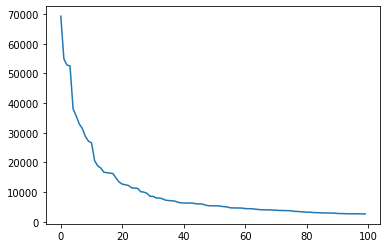

In [48]:
import matplotlib.pyplot as plt
%matplotlib inline
first_100_freqs = [freq for word, freq in freq_dict_sorted[:100]]
plt.plot(first_100_freqs)
plt.show()

Закон Хипса -- обратная сторона закона Ципфа. Он описывает, что чем больше корпус, тем меньше новых слов добавляется с добавлением новых текстов. В какой-то момент корпус насыщается.

## Задание 1.

**Задание**: обучите три классификатора: 

1) на токенах с высокой частотой 

2) на токенах со средней частотой 

3) на токенах с низкой частотой

Сравните полученные результаты, оцените какие токены наиболее важные для классификации.

In [103]:
fds_hf = dict(sorted(freq_dict.items(), key=lambda x: -x[1])[:100])
lst_hf = list(fds_hf.keys())
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(lst_hf)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train[:100])
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.66      0.48      0.55     38132
    positive       0.31      0.49      0.38     18577

    accuracy                           0.48     56709
   macro avg       0.48      0.48      0.47     56709
weighted avg       0.54      0.48      0.50     56709



In [104]:
fds_mf = dict(sorted(freq_dict.items(), key=lambda x: -x[1])[round(len(freq_dict)/2)-50:round(len(freq_dict)/2)+50])
lst_mf = list(fds_mf.keys())
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(lst_mf)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train[:100])
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      0.49      0.66     56673
    positive       0.00      0.61      0.00        36

    accuracy                           0.49     56709
   macro avg       0.50      0.55      0.33     56709
weighted avg       1.00      0.49      0.66     56709



In [109]:
fds_lf = dict(sorted(freq_dict.items(), key=lambda x: -x[1])[-100:])
lst_lf = list(fds_lf.keys())
vec = TfidfVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(lst_lf)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train[:100])
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.91      0.52      0.66     48795
    positive       0.18      0.67      0.29      7914

    accuracy                           0.54     56709
   macro avg       0.55      0.60      0.47     56709
weighted avg       0.81      0.54      0.61     56709



## О важности эксплоративного анализа

Но иногда пунктуация бывает и не шумом -- главное отталкиваться от задачи. Что будет если вообще не убирать пунктуацию?

In [49]:
vec = TfidfVectorizer(ngram_range=(1, 1), tokenizer=nltk.word_tokenize)
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       1.00      1.00      1.00     27813
    positive       1.00      1.00      1.00     28896

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



Шок! Стоило оставить пунктуацию -- и все метрики равны 1. Как это получилось? Среди неё были очень значимые токены (как вы думаете, какие?). Найдите фичи с самыми большими коэффициэнтами:

## Задание 2.

найти фичи с наибольшей значимостью, и вывести их

In [113]:
list(fds_hf.keys())

['не',
 'и',
 'в',
 'я',
 'RT',
 'на',
 'http',
 'что',
 '...',
 'с',
 'а',
 'меня',
 'у',
 'как',
 'так',
 'D',
 'это',
 'мне',
 'все',
 'ты',
 'но',
 "''",
 'Я',
 '``',
 'то',
 'по',
 'уже',
 'за',
 'же',
 'ну',
 'А',
 'только',
 'бы',
 'еще',
 'да',
 'вот',
 'тебя',
 'нет',
 'когда',
 'очень',
 'к',
 'будет',
 'сегодня',
 'день',
 'хочу',
 'он',
 'просто',
 'от',
 'было',
 'тебе',
 'из',
 'мы',
 'И',
 'тоже',
 '—',
 'до',
 'там',
 'надо',
 'даже',
 'его',
 'теперь',
 'есть',
 'вообще',
 'если',
 'для',
 'о',
 'нас',
 'В',
 'завтра',
 'она',
 'могу',
 'Не',
 'всё',
 'Ну',
 'буду',
 'сейчас',
 'У',
 'Как',
 'знаю',
 'без',
 'тут',
 'раз',
 'кто',
 'они',
 'или',
 'люблю',
 'больше',
 'ничего',
 'со',
 '2',
 'про',
 'вы',
 'всегда',
 'блин',
 'Но',
 'почему',
 'можно',
 '3',
 'С',
 'чем']

Посмотрим, как один из супер-значительных токенов справится с классификацией безо всякого машинного обучения:

In [112]:
cool_token = list(fds_hf.keys())[0]
pred = ['positive' if cool_token in tweet else 'negative' for tweet in x_test]
print(classification_report(pred, y_test))

              precision    recall  f1-score   support

    negative       0.47      0.44      0.45     29761
    positive       0.42      0.45      0.43     26948

    accuracy                           0.44     56709
   macro avg       0.44      0.44      0.44     56709
weighted avg       0.45      0.44      0.44     56709



## Символьные n-граммы

Теперь в качестве фичей используем, например, униграммы символов:

In [58]:
vec = CountVectorizer(analyzer='char', ngram_range=(1, 1))
bow = vec.fit_transform(x_train)
clf = LogisticRegression(random_state=42)
clf.fit(bow, y_train)
pred = clf.predict(vec.transform(x_test))
print(classification_report(pred, y_test))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

    negative       0.99      1.00      1.00     27723
    positive       1.00      0.99      1.00     28986

    accuracy                           1.00     56709
   macro avg       1.00      1.00      1.00     56709
weighted avg       1.00      1.00      1.00     56709



В общем-то, теперь уже понятно, почему на этих данных здесь 1. Так или инчае, на символах классифицировать тоже можно: для некторых задач (например, для определения языка) фичи-символьные n-граммы решительно рулят.

Ещё одна замечательная особенность фичей-символов: токенизация и лемматизация не нужна, можно использовать такой подход для языков, у которых нет готвых анализаторов.

1.препроцессинг
2.векторизация
3.обучение классификатора (например, логистическая регрессия)


idf_ степерь важности признаков